> Project summary

# EDA and preprocessing            
- EDA
- PREPROCESSING
# Linear regression model (baseline)   
- Coefficients                                                      
# Limit overfitting by training a regularized regression model                                      
- RIDGE
- LASSO
- ELASTICNET

In [1]:
# Import libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge , Lasso , ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot

In [2]:
# import dataset
df = pd.read_csv('Walmart_Store_sales.csv')

#                  EDA and preprocessing

## --------------------EDA---------------------=

In [3]:
# Display dataset informations
df.info()
print("")
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB



,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


In [4]:
# Display Weekly sales (target) distribution
fig = px.box(df, y="Weekly_Sales",
                   title= "Weekly sales distribution"
                   )

fig.update_layout(title_x = 0.5,
                  margin=dict(l=50,r=50,b=50,t=50,pad=4),
                  yaxis_title = 'Weely sales',
                  xaxis = {'visible': False},
                  template = 'plotly_dark'
                  )

fig.show()

In [5]:
# Display weekly sales by temperature
fig = px.scatter(df, x = "Temperature",
                   y="Weekly_Sales",
                   title= "Weekly sales by temperature"
                   )

fig.update_layout(title_x = 0.5,
                  margin=dict(l=50,r=50,b=50,t=50,pad=4),
                  xaxis_title = 'Temperature',
                  yaxis_title = 'Weekly sales',
                  template = 'plotly_dark'
                  )

fig.show()

In [6]:
# Display weekly sales by stores
fig = px.histogram(df, x = "Store",
                   y="Weekly_Sales",
                   title = 'Weekly sales by stores',
                   text_auto=True
                  )
fig.update_traces(textposition = 'outside', textfont_size = 15)                 
fig.update_layout(title_x = 0.5,
                  margin=dict(l=50,r=50,b=50,t=50,pad=4),
                  xaxis_title = 'Stores',
                  yaxis_title = 'Weekly sales',
                  template = 'plotly_dark'
                  )                  
fig.show()

In [7]:
# Drop the lines in the dataset for which the value in Weekly_Sales is missing.
df = df.loc[df['Weekly_Sales'].notna(),:]

In [8]:
# Create columns ("year, month, day") from "Date" column
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day

<AxesSubplot:>

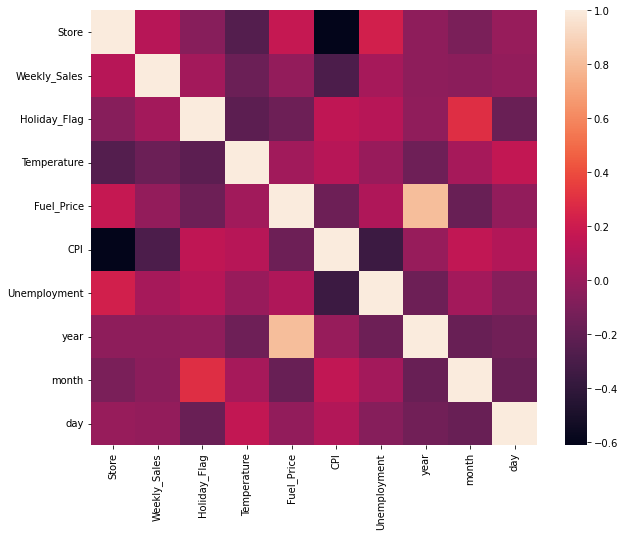

In [9]:
# Display correlation heatmap
corr = df.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, ax=ax)

In [10]:
# Display weekly sales distribution by month
fig = px.box(df, y="Weekly_Sales", 
             x = "month",
             title= "Weekly sales distribution by month"
             )

fig.update_layout(title_x = 0.5,
                  margin=dict(l=50,r=50,b=50,t=50,pad=4),
                  xaxis_title = 'Month',
                  yaxis_title = 'Weekly Sales',
                  template = 'plotly_dark'
                  )

fig.show()

> The EDA reveal correlations between features but poor correlation with the target

> Some of the features have outliers 

> To predict the weekly sales and build or regression model we need to preprocess the data

## --------------PREPROCESSING--------------------


In [11]:
# Create variables defined by the formula [𝑋¯−3𝜎 , 𝑋¯+3𝜎]
uppertemp = df['Temperature'].mean()+(3*df['Temperature'].std())
lowertemp = df['Temperature'].mean()-(3*df['Temperature'].std())
upperfuel = df['Fuel_Price'].mean()+(3*df['Fuel_Price'].std())
lowerfuel = df['Fuel_Price'].mean()-(3*df['Fuel_Price'].std())
uppercpi = df['CPI'].mean()+(3*df['CPI'].std())
lowercpi = df['CPI'].mean()-(3*df['CPI'].std())
upperunmp = df['Unemployment'].mean()+(3*df['Unemployment'].std())
lowerunmp = df['Unemployment'].mean()-(3*df['Unemployment'].std())

In [12]:
# Create new dataframe without outliers using above variables
df = df[(df["Temperature"] < uppertemp) & (df["Temperature"] > lowertemp)]
df = df[(df["Fuel_Price"] < upperfuel) & (df["Fuel_Price"] > lowerfuel)]
df = df[(df["CPI"] < uppercpi) & (df["CPI"] > lowercpi)]
df = df[(df["Unemployment"] < upperunmp) & (df["Unemployment"] > lowerunmp)]

In [13]:
# Create X and Y for the train test split
features_list = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'year', 'month', 'day','Store', 'Holiday_Flag']
target_variable = "Weekly_Sales"
X = df.loc[:,features_list]
Y = df.loc[:,target_variable]

In [14]:
# Train test split with test size 30% and random state 42
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [15]:
# Prepocessing
# Define categorical and numerical features
numeric_features = [0,1,2,3,4,5,6]
categorical_features = [7,8]
# Create numerical and categorical variables tranformers with pipelines function
# Use SimpleImputer to change missing numerical values with the median and standardScaler to standardize numerical values
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# Use SimpleImputer to change missing categorical values with the most frequent value and OneHotEncoder to assign a code to values
# The paramater drop = 'first' delete the first code column to avoid colinearity 
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
])
# Create preprocess variable by using ColumnTransformer function to apply the different tranformers in the pipelines
preprocess = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_features),
        ('cat', cat_transformer, categorical_features)
    ])
# Apply preprocess on the X_train with fit_transform function (calculate the mean and variance of training set with 'fit' method)
X_train = preprocess.fit_transform(X_train)
# Apply preprocess on the X_test with transform function fit on the training set.
X_test = preprocess.transform(X_test)

# Linear regression model (baseline) 

In [16]:
# Training linear regression model
# Call LinearRegression function
regressor = LinearRegression()
# Fit the training set with the linear regression function
regressor.fit(X_train, Y_train)

LinearRegression()

In [17]:
# Make prediction with the function fit on the training set
# Create variable containing the target prediction on train set
Y_train_pred = regressor.predict(X_train)
# Create variable containing the target prediction on test set
Y_test_pred = regressor.predict(X_test)

In [18]:
# Display R2 scores for this model
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9788332739806356
R2 score on test set :  0.9546920986439397


> The baseline model offer very good prediction with a nice R2 score

> With 0.024 difference on train and test set we are looking for an overfitting reduction

## --------- Coefficients -----------

In [19]:
# Take features names from the preprocessing
feat_1 = preprocess.transformers_[1][1].steps[1][1].get_feature_names().tolist()
feat_2 = X.columns[:-2].to_list()

In [20]:
# Transform in array the two list and concatenate
features = np.array(feat_1 + feat_2)

In [21]:
# Create datafreame from features names and model coefficients
df_coef = pd.DataFrame([regressor.coef_],columns=features).T.reset_index()

In [22]:
# Rename columns
df_coef.columns = ['features','Coefficients']

In [23]:
# Change coefficients values in absolute values 
df_coef.Coefficients = df_coef.Coefficients.abs()

In [24]:
# display feature coefficients for the baseline model
fig = px.bar(df_coef.sort_values(by=['Coefficients'], ascending=True), y= 'features', x = "Coefficients",
                   title = 'Features coefficients for the baseline model',
                   text_auto=True,
                   height= 500
                  )
fig.update_traces(textposition = 'outside', textfont_size = 15)                 
fig.update_layout(title_x = 0.5,
                  margin=dict(l=50,r=50,b=50,t=50,pad=4),
                  yaxis_title = 'Features',
                  xaxis = {'visible': False}, 
                  template = 'plotly_dark'
                  )                  
fig.show()

> The top 5 features for the baseline prediction model are 3 stores (11, 20 & 18), the year and the Unemployement.

# Limit the overfitting by training a regularized regression model 

## ---------RIDGE--------

In [25]:
# Define steps for the grid search
step = [0.001*i for i in range(1, 101)]
step_tol = [0.001*i for i in range(1, 101)]
# Perform grid search
# Call Ridge regulizer
regressor = Ridge()
# Define hyperparameters alpha and tol search 
params = {'alpha': step,
          'tol': step_tol
          }
'''
tol parameter = This parameter represents the tolerance for the optimization. 
The tol value and updates would be compared and if found updates smaller than tol, 
the optimization checks the dual gap for optimality and continues until it is smaller than tol."
'''        
# Define GridSearchCV with a 10 folds cross validation 
gridsearch = GridSearchCV(regressor,
                          param_grid = params, 
                          cv = 10,
                          verbose = 1
                          ) 
# Fit grid search on training set
gridsearch.fit(X_train, Y_train)
# Print the best hyperparameters and the best R2_score
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best score : ", gridsearch.best_score_)

Fitting 10 folds for each of 10000 candidates, totalling 100000 fits
Best hyperparameters :  {'alpha': 0.003, 'tol': 0.001}
Best score :  0.9236650309361705


In [26]:
# Make prediction with the function fit on the train set
# Create variable containing the target prediction on train set
Y_train_pred_ridge = gridsearch.predict(X_train)
# Create variable containing the target prediction on test set
Y_test_pred_ridge = gridsearch.predict(X_test)

In [27]:
# Display R2 scores for this model
print("R2 score on training set: ", r2_score(Y_train, Y_train_pred_ridge))
print("R2 score on test set: ", r2_score(Y_test, Y_test_pred_ridge))

R2 score on training set:  0.9780575963884338
R2 score on test set:  0.9629691372361614


> The model with ridge regularization offer also very good prediction with nice R2_score

> The overfitting is limited With 0.016 difference on train and test set

> Let's try with lasso regularization

## ---------LASSO--------

In [28]:
# Define steps for the grid search
step = [0.01*i for i in range(1, 101)]
step_tol = [0.001*i for i in range(1, 101)]
# Perform grid search
# Call Lasso regulizer with a maximum itration set on 100k
regressor = Lasso(max_iter=100000)
# Define hyperparameters alpha and tol search 
params = {'alpha': step,
          'tol': step_tol
          }
# Define GridSearch with a 10 folds cross validation
gridsearch = GridSearchCV(regressor,
                          param_grid = params,
                          cv = 10,
                          verbose = 1
                          )
# Fit grid search on train set
gridsearch.fit(X_train, Y_train)
# Print the best hyperparameters and the best R2_score
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best score : ", gridsearch.best_score_)

Fitting 10 folds for each of 10000 candidates, totalling 100000 fits
Best hyperparameters :  {'alpha': 0.21, 'tol': 0.011}
Best score :  0.8973280569282511


In [29]:
# Make prediction with the function fit on the train set
# Create variable containing the target prediction on train set
Y_train_pred_lasso = gridsearch.predict(X_train)
# Create variable containing the target prediction on test set
Y_test_pred_lasso = gridsearch.predict(X_test)

In [30]:
# Display R2 scores for this model
print("R2 score on training set: ", r2_score(Y_train, Y_train_pred_lasso))
print("R2 score on test set: ", r2_score(Y_test, Y_test_pred_lasso))

R2 score on training set:  0.9779860658084715
R2 score on test set:  0.962840288767029


> The model with lasso regularization offer also very good prediction with nice R2_score

> The overfitting is limited With 0.015 difference on train and test set

> Let's try with a combination of lasso and ridge regularization, ElasticNet regulizer

## ---------ELASTICNET--------

In [31]:
step = [0.001*i for i in range(1, 101)]
step_tol = [0.0001*i for i in range(1, 101)]
step_ratio = [0.1*i for i in range(1, 11)]
# Perform grid search
print("Grid search...")
regressor = ElasticNet(max_iter=100000)
# Grid of values to be tested
params = {'alpha': step,
          'tol': step_tol,
          'l1_ratio' : step_ratio
          }
gridsearch = GridSearchCV(regressor,
                          param_grid = params, 
                          cv = 3,
                          verbose = 1
                          ) 
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best score : ", gridsearch.best_score_)

Grid search...
Fitting 3 folds for each of 100000 candidates, totalling 300000 fits
...Done.
Best hyperparameters :  {'alpha': 0.001, 'l1_ratio': 0.9, 'tol': 0.0074}
Best score :  0.92540696027989


In [32]:
# Make prediction with the function fit on the train set
# Create variable containing the target prediction on train set
Y_train_pred_elastic = gridsearch.predict(X_train)
# Create variable containing the target prediction on test set
Y_test_pred_elastic = gridsearch.predict(X_test)

In [33]:
# Display R2 scores for this model
print("R2 score on training set: ", r2_score(Y_train, Y_train_pred_elastic))
print("R2 score on test set: ", r2_score(Y_test, Y_test_pred_elastic))

R2 score on training set:  0.9777553420008512
R2 score on test set:  0.9636164002555214


> The model with ElasticNet regularization offer also very good prediction with nice R2_score

> The overfitting is limited With 0.014 difference on train and test set